In [1]:
#import packages
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr
import functools as ft
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry
plt.rcParams['font.size'] = 14


Figure 1: Multimodel median of SST bias relative to NOAA OI SST v2. Stippled where at least 15/20 models agree on sign of bias. This is sginificant at 95% in a binomial test. WTIO, SETIO, and Arabian Sea are outlined in boxes.

In [6]:
datadir = '/home/z5113258/Documents/data/'
figdir = "/home/z5113258/Documents/figures/Figures_high_res/"

In [8]:
#dict with file names
varis = {'SST':'_tos.nc'}
SST_D={}
#get all data for temp tendency
for model in os.listdir(datadir+'CMIP6_HB_new/'):
    #go thorugh all varis
    if model in ['NESM3']:#this model had issues with data so not included
        pass
    else:
        #input file
        inp_files = (os.path.join(datadir+'CMIP6_HB_new/', model, str(model+"_tos.nc")))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #now append data to model dict
            SST_D[model] = var
        except Exception as e:
            print("Error. ", e)
            pass

Error.  [Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tos.nc'


In [4]:
#now get models timeseries
for i, model in enumerate(SST_D.keys()):
    try:    
        sst = SST_D[model]
        #now turn into an array
        if i == 0:
            SSTM = sst
        else:
            SSTM = xr.concat([SSTM, sst], dim = 'model')
    except Exception as e:
            print("something went wrong, here is the error code", e)

In [9]:
#load in SST to compare to
OSST = xr.open_mfdataset(datadir+'NOAA_OISSTv2.nc', parallel=True).sst
LSM = xr.open_dataset(datadir+'LSM.nc').mask
OSST= OSST.where(LSM[0])
OSST = OSST.groupby('time.month').mean('time').sel(lat=slice(-40,30),lon=slice(30,125))

In [10]:
#calculate bias and the significance levels
SSTB = SSTM - OSST
#find cells where pos and negative
SSTB_pos = xr.where(SSTB>0, 1,0)
SSTB_neg = xr.where(SSTB<0, 1,0)
#get where majority of cells agree on sign, ie, at least 15/20
SSTB_pos_ = SSTB_pos.sum('model')
pos = xr.where(SSTB_pos_ >= 15, 1, 0)

SSTB_neg_ = SSTB_neg.sum('model')
neg = xr.where(SSTB_neg_ >= 15, 1, 0)
sigbias = xr.where((pos+neg)==1, 1, np.nan)

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/z5113258/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'facecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/z5113258/anaconda3/lib/python3.8/site-

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

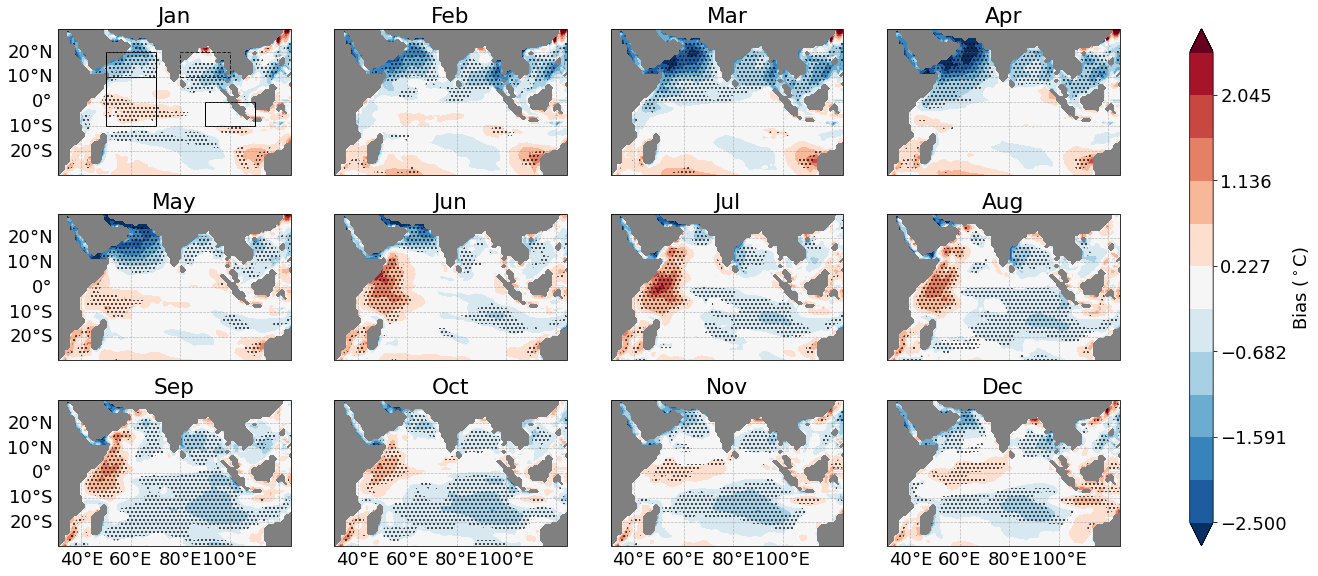

In [11]:
plt.rcParams.update({'font.size': 18})

#plot facet grid
fg = SSTB.median(dim = "model", skipna = True).plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()}, 
                              figsize=(20,8), vmin = -2.5, vmax = 2.5, levels =12,  cmap = 'RdBu_r',
                                cbar_kwargs=dict(label='Bias ($^\circ$C)'))

#Add in features
for i, ax in enumerate(fg.axes.flat):
    ax.contourf(sigbias.lon, sigbias.lat, sigbias[i], [1,2], colors='none', hatches=['...',None])
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    if i in [0,1,2,3,4,5,6,7]:
        gl.bottom_labels = False
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False
    #add in the boxes of interest
    if i == 0:
        ax.add_patch(patches.Rectangle((50,-10), 20, 20, color="k", fill = False, linewidth=1))
        ax.add_patch(patches.Rectangle((50,10), 20, 10, color="k", fill = False, linewidth=1))
        ax.add_patch(patches.Rectangle((90,-10), 20, 10, color="k", fill = False, linewidth=1))
        ax.add_patch(patches.Rectangle((80,10), 20, 10, color="k", fill = False, linewidth=1, linestyle = '--'))

#now add the month labels
titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax,title in zip(fg.axes.flatten(),titles):
    ax.set_title(title )

#plt.savefig(figdir+'F_1.pdf', dpi=600, pad_inches = 1,  bbox_inches = 'tight', facecolor = 'white')
